Can we go from this:

![CartPole balancing random](https://cdn-images-1.medium.com/max/800/1*ohWngM-PVYmDG9KVpOm_xQ.gif)

to this:

![CartPole balancing solved](https://cdn-images-1.medium.com/max/800/1*oMSg2_mKguAGKy1C64UFlw.gif)

using Deep Learning?

We're gonna use [OpenAI's Gym](https://gym.openai.com/):

> Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

Concretely, we will use the [CartPole environment](https://gym.openai.com/envs/CartPole-v0/) first described by [Barto, Sutton, and Anderson 83](http://ieeexplore.ieee.org/document/6313077/).

## What is the objective of CartPole?

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Gym defines CartPole as **solved** as getting average reward of 195.0 over 100 consecutive trials.

## Try it yourself

[Online Pole Balancer](https://richard-towers.com/poleBalancer/)

# Setup

In [1]:
!pip install --upgrade seaborn

# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages


In [2]:
!apt-get install -y cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.9.1-1).
libjpeg-dev is already the newest version (8c-2ubuntu8).
xorg-dev is already the newest version (1:7.7+19ubuntu3).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libav-tools is already the newest version (7:3.3.4-2).
libboost-all-dev is already the newest version (1.62.0.1).
libsdl2-dev is already the newest version (2.0.6+dfsg1-3ubuntu1).
python-opengl is already the newest version (3.1.0+dfsg-1).
swig is already the newest version (3.0.10-1.2).
xvfb is already the newest version (2:1.19.5-0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [3]:
!pip install pyvirtualdisplay


In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [5]:
!pip install gym[atari]

In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from collections import namedtuple, deque
from itertools import count
from copy import deepcopy
from PIL import Image
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
from google.colab import files
from types import SimpleNamespace


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]


sns.set(style='whitegrid', palette='colorblind', font_scale=1.5)

def save_animation(frames, filename="balance"):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
  patch = plt.imshow(frames[0])
  plt.axis('off')

  def animate(i):
      patch.set_data(frames[i])

  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(f'{filename}.mp4', codec='h264')

# Hitting the Gym

Let's start by creating an environment and get to know what Gym can do for us.

## Creating environment

In [7]:
env = gym.make('CartPole-v0')
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([0.00915731, 0.02558982, 0.01087777, 0.03002529])

## Exploring the possible actions

In [8]:
env.action_space

Discrete(2)

## Acting in the environment

In [0]:
random_action = env.action_space.sample()
observation, reward, done, info = env.step(random_action)

The observation vector gives us the following information:

`[position of cart, velocity of cart, angle of pole, rotation rate of pole]`

In [10]:
observation

array([ 0.0096691 , -0.16968643,  0.01147828,  0.32612033])

In [11]:
reward

1.0

## How about a sample of the environment?

(400, 600, 3)


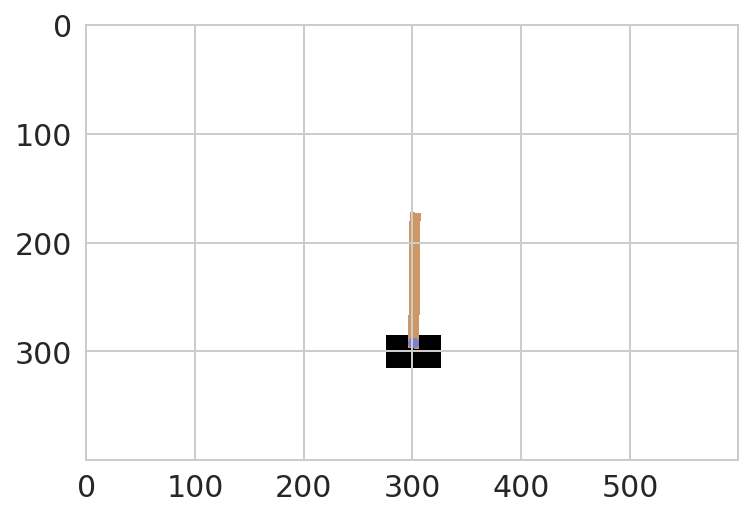

In [12]:
screen = env.render(mode='rgb_array')
plt.imshow(screen, interpolation='none');
print(screen.shape)

## Let's play couple of episodes

In [0]:
frames = []
for _ in range(10):
  env.reset()
  for t in count():
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    if done:
      break

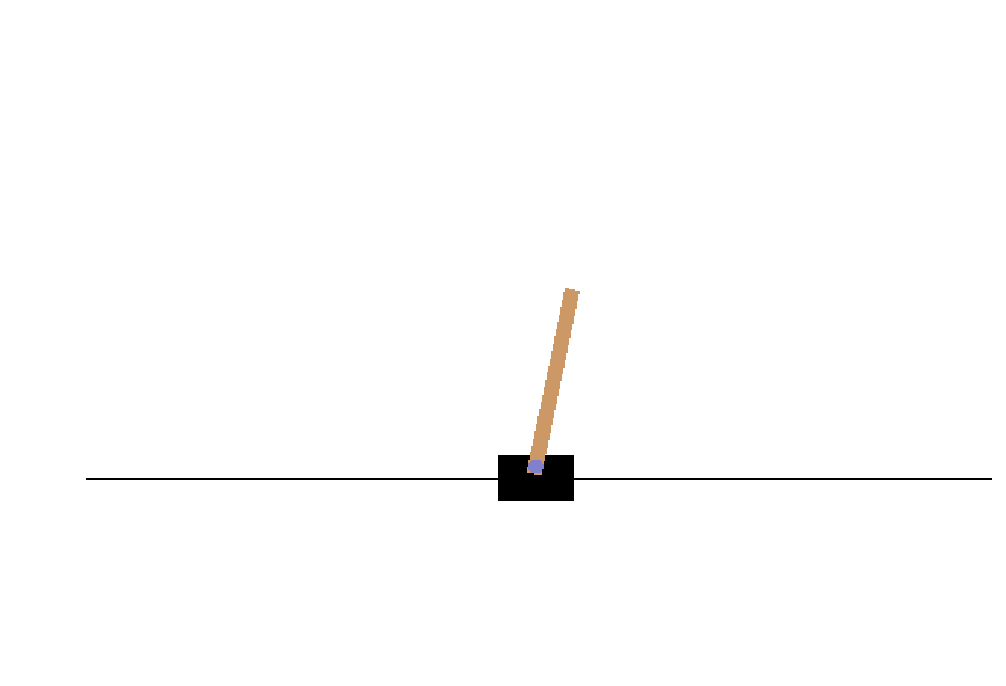

In [14]:
save_animation(frames)

In [15]:
!ls

balance.mp4  datalab


In [0]:
files.download("balance.mp4")

# Experience replay

We will store transitions of state $s$ to state $s'$ along with received reward $r$, chosen action $a$ and whether or not the episode is finished. The data will be used to improve the effectiveness of the learning process for our agent. 

In [0]:
Transition = namedtuple("Transition",
                        field_names=["state", "action", "reward", "next_state", "done"])

class ReplayMemory:
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []

  def push(self, transition):
    self.memory.append(transition)
    if len(self.memory) > self.capacity:
        del self.memory[0]

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)      

# Model

We will use a Deep Neural Network with 2 hidden layers that accepts observation from the environment and has 2 neurons (the number of actions) in the output layer:

In [0]:
class DQN(nn.Module):
  
  def __init__(self, input_dim, output_dim, hidden_dim):

    super().__init__()

    self.fc1 = nn.Sequential(
      nn.Linear(input_dim, hidden_dim),
      nn.BatchNorm1d(hidden_dim),
      nn.PReLU()
    )

    self.fc2 = nn.Sequential(
      nn.Linear(hidden_dim, hidden_dim),
      nn.BatchNorm1d(hidden_dim),
      nn.PReLU()
    )

    self.out = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):

    x = self.fc1(x)
    x = self.fc2(x)
    return self.out(x)

Note that we use [PReLu](http://pytorch.org/docs/master/nn.html#torch.nn.PReLU) as activation function:

![ReLu vs PReLu](https://qph.fs.quoracdn.net/main-qimg-c53738b46b0b4a46bb6253d874779cb3)

# Agent

Our agent will be responsible for choosing action given some state $s$

In [0]:
class Agent(object):

  def __init__(self, input_dim, output_dim, hidden_dim):

    self.dqn = DQN(input_dim, output_dim, hidden_dim)
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.loss_fn = nn.MSELoss()
    self.optim = torch.optim.Adam(self.dqn.parameters())
    self.replay_memory = ReplayMemory(Config.capacity)

  def _to_variable(self, x):

    return Variable(torch.Tensor(x))

  def choose_action(self, states, eps = 0):

      if np.random.rand() < eps:
          return np.random.choice(self.output_dim)
      else:
          scores = self.q_val(states)
          _, argmax = torch.max(scores.data, 1)
          return int(argmax.numpy())

  def q_val(self, states):

    states = self._to_variable(states.reshape(-1, self.input_dim))
    self.dqn.eval()
    return self.dqn(states)

  def train(self, Q_current, Q_expected):

    self.dqn.train()
    self.optim.zero_grad()
    loss = self.loss_fn(Q_current, Q_expected)
    loss.backward()
    self.optim.step()

    return loss

  def learn(self, transition):

    self.replay_memory.push(transition)
    if len(self.replay_memory) < Config.batch_size:
      return

    minibatch = self.replay_memory.sample(Config.batch_size)

    states = np.vstack([x.state for x in minibatch])
    actions = np.array([x.action for x in minibatch])
    rewards = np.array([x.reward for x in minibatch])
    next_states = np.vstack([x.next_state for x in minibatch])
    done = np.array([x.done for x in minibatch])

    Q_current = self.q_val(states)
    Q_expected = Q_current.clone().data.numpy()
    Q_expected[np.arange(len(Q_expected)), actions] = rewards + Config.gamma * np.max(self.q_val(next_states).data.numpy(), axis=1) * ~done

    return self.train(Q_current, self._to_variable(Q_expected))

# Training

In [0]:
def run_episode(env, agent, eps, batch_size):
  
  state = env.reset()
  done = False
  total_reward = 0

  while not done:

    action = agent.choose_action(state, eps)
    next_state, reward, done, info = env.step(action)

    total_reward += reward

    if done:
        reward = -1

    agent.learn(Transition(state, action, reward, next_state, done))

    state = next_state

  return total_reward

In [0]:
def find_epsilon(episode, max_episode, min_eps):
    """Returns 𝜺-greedy
    1.0---|\
          | \
          |  \
    min_e +---+------->
              |
              max_episode
    Args:
        episode: Current episode (0<= episode)
        max_episode: After max episode, 𝜺 will be `min_eps`
        min_eps: 𝜺 will never go below this value
    """

    slope = (min_eps - 1.0) / max_episode
    return max(slope * episode + 1.0, min_eps)

In [27]:
Config = dict(
    gamma=0.99, 
    batch_size=64, 
    hidden_dim=12, 
    capacity=50000, 
    max_episode=50, 
    min_eps=0.01, 
    n_episode=1000
)
Config = SimpleNamespace(**Config)


rewards = []
agent = Agent(input_dim=4, output_dim=2, hidden_dim=Config.hidden_dim)

for i in range(Config.n_episode):
    eps = find_epsilon(i, Config.max_episode, Config.min_eps)
    r = run_episode(env, agent, eps, Config.batch_size)
    if i % 10 == 0:
      print("[Episode: {:5}] Reward: {:5} 𝜺-greedy: {:5.2f}".format(i + 1, r, eps))

    rewards.append(r)

    if len(rewards) >= 100:
        
        last_100 = rewards[-100:]
        if np.mean(last_100) >= 195:
            print(f"Objective complete in {i + 1} episodes with mean reward {np.mean(last_100)}")
            break

[Episode:     1] Reward:   9.0 𝜺-greedy:  1.00
[Episode:    11] Reward:  12.0 𝜺-greedy:  0.80
[Episode:    21] Reward:  15.0 𝜺-greedy:  0.60
[Episode:    31] Reward:  16.0 𝜺-greedy:  0.41
[Episode:    41] Reward:   8.0 𝜺-greedy:  0.21
[Episode:    51] Reward:   9.0 𝜺-greedy:  0.01
[Episode:    61] Reward:  10.0 𝜺-greedy:  0.01
[Episode:    71] Reward:   9.0 𝜺-greedy:  0.01
[Episode:    81] Reward:   8.0 𝜺-greedy:  0.01
[Episode:    91] Reward:   9.0 𝜺-greedy:  0.01
[Episode:   101] Reward:  44.0 𝜺-greedy:  0.01
[Episode:   111] Reward:  66.0 𝜺-greedy:  0.01
[Episode:   121] Reward:  87.0 𝜺-greedy:  0.01
[Episode:   131] Reward: 140.0 𝜺-greedy:  0.01
[Episode:   141] Reward: 150.0 𝜺-greedy:  0.01
[Episode:   151] Reward: 200.0 𝜺-greedy:  0.01
[Episode:   161] Reward: 185.0 𝜺-greedy:  0.01
[Episode:   171] Reward: 181.0 𝜺-greedy:  0.01
[Episode:   181] Reward: 200.0 𝜺-greedy:  0.01
[Episode:   191] Reward: 200.0 𝜺-greedy:  0.01
[Episode:   201] Reward: 200.0 𝜺-greedy:  0.01
[Episode:   2

# Evaluation

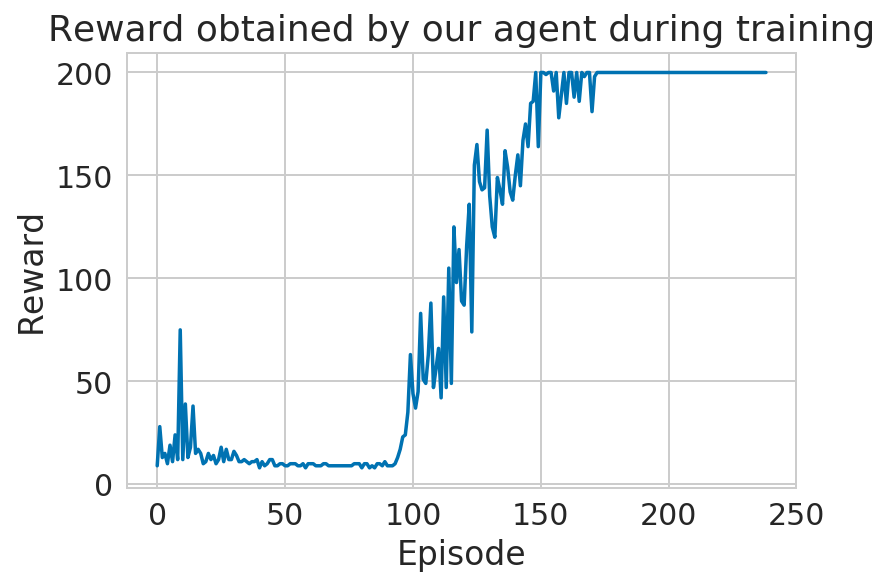

In [28]:
plt.title('Reward obtained by our agent during training')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(rewards);

## Can our trained Agent balance the pole?

In [0]:
frames = []
for _ in range(10):
  state = env.reset()
  for t in count():
      frames.append(env.render(mode = 'rgb_array'))
      action = agent.choose_action(state)
      state, _, done, _ = env.step(action)
      if done:
          break

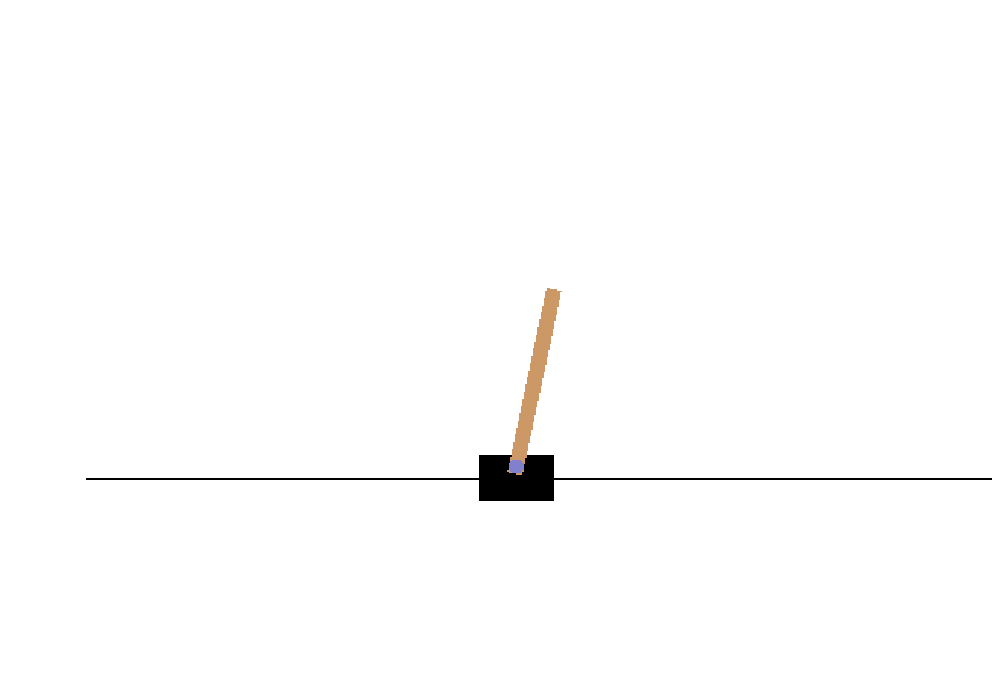

In [25]:
save_animation(frames, "balance_trained")

In [0]:
files.download("balance_trained.mp4")